In [1]:
import sys
import torch
sys.path.append('../')

from utils.fit_ellipse import transform_tensor_batched, ellipse_params_batched, plot_batch_with_ellipses, ellipse_fit_metric, ellipse_params_from_moments
from utils.utils_train import BestEllipseLoss, MomentBasedLoss
from utils.utils_data import get_dataloader
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_path='/home/michaelbertagna/git/Galaxy-Deconv/simulated_datasets/LSST_23.5_deconv'
train_val_split=0.8
batch_size=2
train_loader, val_loader = get_dataloader(data_path=data_path, train=True, train_val_split=train_val_split, batch_size=batch_size)

In [ ]:
train_iter = iter(train_loader)
(obs, psf, alpha), gt = next(train_iter)

print(f"obs shape: {obs.shape}, psf shape: {psf.shape}, alpha shape: {alpha.shape}")
print(f"gt shape: {gt.shape}")

tensor(14807.5645, grad_fn=<AddBackward0>)


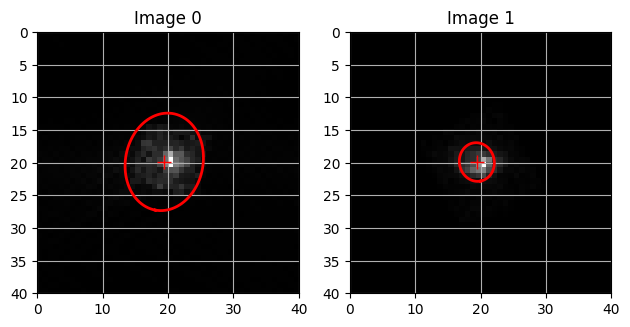

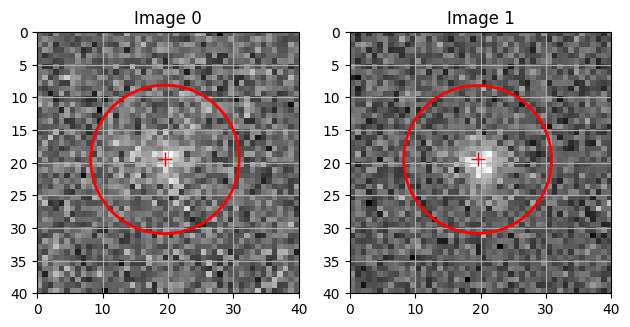

In [ ]:
import time
from IPython.display import clear_output
import numpy as np

loss_fn = MomentBasedLoss()

for idx, ((obs, psf, alpha), gt) in enumerate(train_loader):
    clear_output()
    params_sets_gt = ellipse_params_from_moments(gt)
    params_sets_obs = ellipse_params_from_moments(obs)
    print(loss_fn(gt, obs))
    fig, axes = plot_batch_with_ellipses(gt, [params_sets_gt], num_cols=2)
    plt.show()
    fig, axes = plot_batch_with_ellipses(obs, [params_sets_obs], num_cols=2)
    plt.show()
    time.sleep(3)

LOSS: tensor(2.8280, grad_fn=<MeanBackward0>)
 GT Enclosed Brightness (r) tensor([0.9263, 0.9132], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (g) tensor([0.9231, 0.9285], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (b) tensor([0.9229, 0.9217], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (c) tensor([0.9224, 0.8186], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (m) tensor([0.9227, 0.6043], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (y) tensor([0.9242, 0.8797], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (r) tensor([0.9270, 0.9048], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (g) tensor([0.9289, 0.8786], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (b) tensor([0.9303, 0.8664], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (c) tensor([0.9309, 0.8538], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (m) tensor([0.9327, 0.8355], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (y) tensor([0.9335, 0.8192], grad_fn=<DivBackward0>)
 GT Enclosed Brightness (r) te

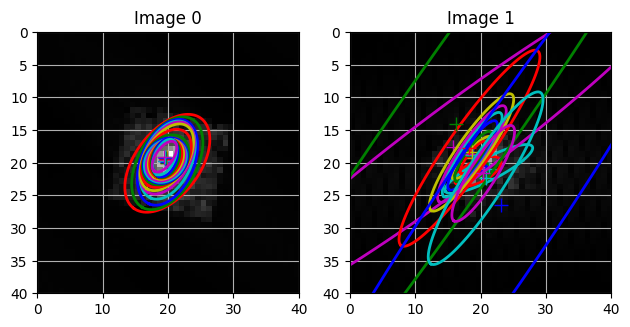

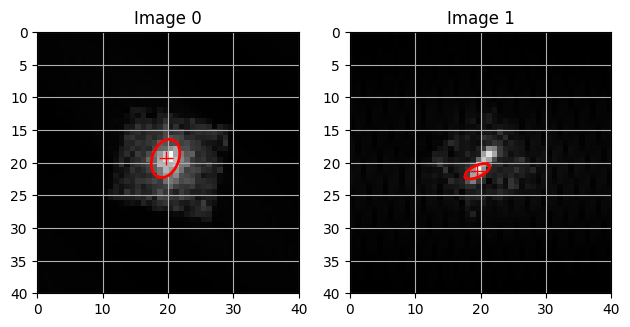

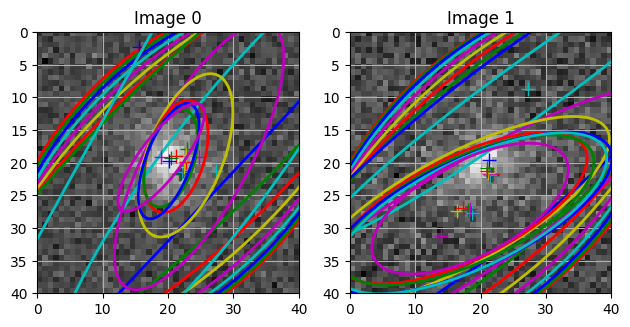

In [ ]:
import time
from IPython.display import clear_output
import numpy as np

step = 0.025
# step = 0.1
pps = np.arange(start=0.3, stop=0.7+step, step=step)
color_codes = ['r', 'g', 'b', 'c', 'm', 'y']

loss_fn = loss_fn = BestEllipseLoss(
    ellipse_levels=pps,
    center_weight=1.0, 
    angle_weight=0.5, 
    axis_weight=1.0
    )

for idx, ((obs, psf, alpha), gt) in enumerate(train_loader):
    clear_output()
    params_sets_gt, mean_sam_dists_gt = zip(*[ellipse_params_batched(transform_tensor_batched(gt), peak_pos=pp) for pp in pps])
    params_sets_obs, mean_sam_dists_obs = zip(*[ellipse_params_batched(transform_tensor_batched(obs), peak_pos=pp) for pp in pps])
    print(                  'LOSS:', loss_fn(gt, obs))
    max_idx0 = 0
    max_idx1 = 0
    max0 = 0
    max1 = 0
    for i in range(len(pps)):
        efm = ellipse_fit_metric(gt, params_sets_gt[i])
        print(f' GT Enclosed Brightness ({color_codes[i%len(color_codes)]})', efm)
        if efm[0] > max0:
            max0, max_idx0 = efm[0], i
        if efm[1] > max1:
            max1, max_idx1 = efm[1], i
        # print('OBS Enclosed Brightness', ellipse_fit_metric(obs, params_sets_obs[i]))
    # print([(pps[i], color_codes[i%len(color_codes)], mean_sam_dists_gt) for i in range(len(pps))])
    fig, axes = plot_batch_with_ellipses(gt, list(params_sets_gt), num_cols=2)
    fig, axes = plot_batch_with_ellipses(gt, [torch.stack([params_sets_gt[max_idx0][0], params_sets_gt[max_idx1][1]])], num_cols=2)
    plt.show()
    # print([(pps[i], color_codes[i%len(color_codes)], mean_sam_dists_obs) for i in range(len(pps))])
    fig, axes = plot_batch_with_ellipses(obs, list(params_sets_obs), num_cols=2)
    plt.show()
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_obs, params_sets_gt)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_gt, params_sets_obs)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_gt, params_sets_gt)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_obs, params_sets_obs)])
    time.sleep(3)